In [1]:
!pip install -q keras-tqdm

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.keras import TqdmCallback
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

In [3]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_1"
os.chdir(folder_path)

In [4]:
df = pd.read_csv("data/housing.csv")

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df = df.drop('ocean_proximity', axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
print(df.isnull().sum())
print(np.isinf(df).sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64


In [9]:
df = df.dropna()
df = df[~np.isinf(df).any(axis=1)]

In [10]:
# target values "housing_median_age"
X = df.drop("housing_median_age", axis=1).values
y = df["housing_median_age"].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Architecture

In [12]:
Dense = tf.keras.layers.Dense
Input = tf.keras.layers.Input
Dropout = tf.keras.layers.Dropout
Sequential = tf.keras.models.Sequential
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

In [13]:
# ANN Model
ann = tf.keras.Sequential([
    Input(shape=(8,)),
    Dense(units=10, activation="relu"),
    Dense(units=5, activation="relu"),
    Dense(units=1)
])

ann.compile(optimizer=optimizer, loss="mean_squared_error")

In [14]:
history = ann.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test),
                  verbose=0, callbacks=[early_stopping,reduce_lr,TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


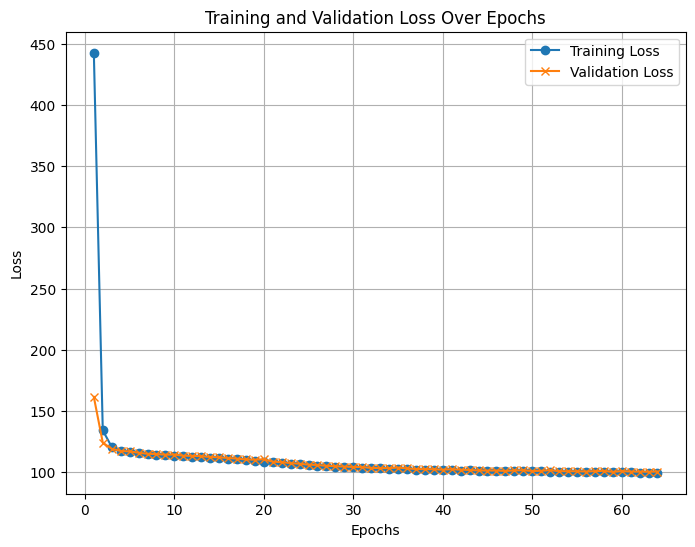

In [15]:
# Extract loss and validation loss from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting the losses
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Error Metrics
predictions = ann.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 7.980006514047392, MSE: 100.62335754866551, RMSE: 10.031119456404928, R-squared: 0.37118220452943107


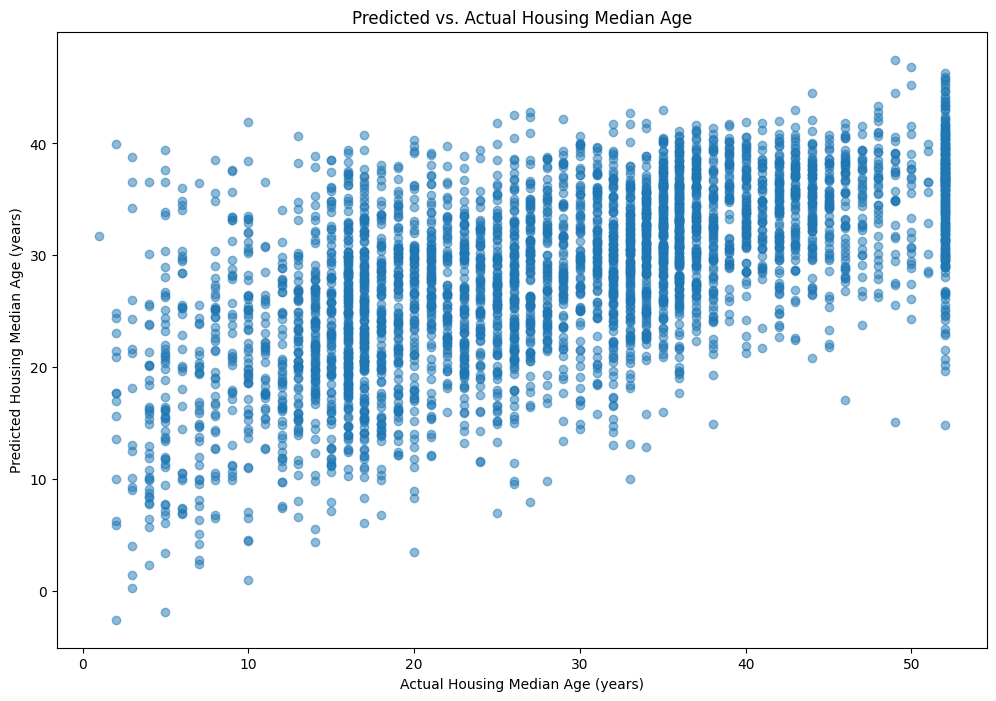

In [17]:
# Visualization: Predicted vs Actual
plt.figure(figsize=(12, 8))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel("Actual Housing Median Age (years)")
plt.ylabel("Predicted Housing Median Age (years)")
plt.title("Predicted vs. Actual Housing Median Age")
plt.show()

## Emphasizing

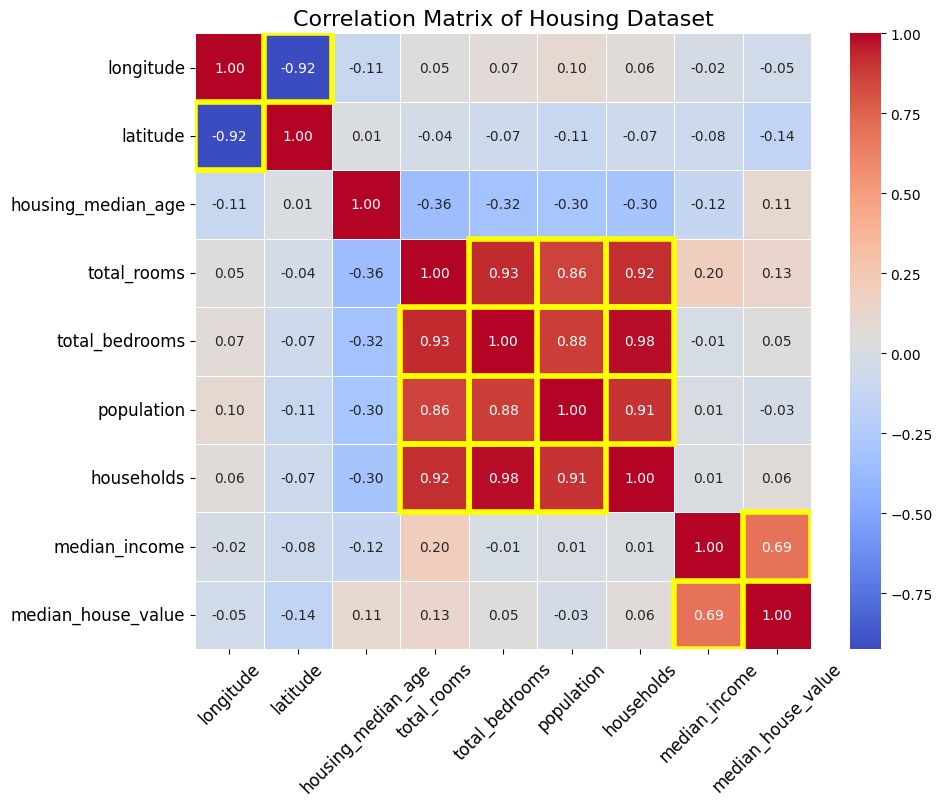

In [18]:
# Correlation Heatmap with highlight high corr
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))

# heatmap
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=True,   # Mask the diagonal
    square=True
)

# Highlight correlations > 0.5 or < -0.5
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j and (correlation_matrix.iloc[i, j] > 0.5 or correlation_matrix.iloc[i, j] < -0.5):
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='yellow', linewidth=4))

plt.title("Correlation Matrix of Housing Dataset", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

# New section

In [19]:
# Median of Target
print("Median of Housing Median Age:")
print(df['housing_median_age'].median())

Median of Housing Median Age:
29.0


# Imagenary Data

In [20]:
imaginary_data = np.array([
    [5.0, 300, 2.0, 3.0, 2.0, 120.0, 600.0, 200000.0],
    [10.0, 800, 5.0, 5.0, 4.0, 200.0, 1000.0, 350000.0]
])
scaled_imaginary_data = scaler.transform(imaginary_data)

In [21]:
scaled_imaginary_data = scaler.transform(imaginary_data)
imaginary_predictions = ann.predict(scaled_imaginary_data)
print("Imaginary Data Predictions:")
for i, pred in enumerate(imaginary_predictions):
    print(f"Input {i+1}: Predicted Housing Median Age is {pred[0]:.2f} years")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Imaginary Data Predictions:
Input 1: Predicted Housing Median Age is 34.48 years
Input 2: Predicted Housing Median Age is 533.53 years


#GUI

https://colab.research.google.com/drive/1BcMwDr6QpyLypoxcG994yaTwNdNdGN8W?usp=sharing#scrollTo=QFiDSIaEo3AO

In [22]:
temp_input = widgets.FloatText(
    value=25.0,
    description='Temperature:',
    tooltip='Enter the Average Temperature (°C)'
)
vacuum_input = widgets.FloatText(
    value=60.0,
    description='Vacuum:',
    tooltip='Enter the Exhaust Vacuum (hPa)'
)
pressure_input = widgets.FloatText(
    value=1010.0,
    description='Pressure:',
    tooltip='Enter the Ambient Pressure (hPa)'
)
humidity_input = widgets.FloatText(
    value=50.0,
    description='Humidity:',
    tooltip='Enter the Relative Humidity (%)'
)

# Button
predict_button = widgets.Button(
    description="Predict",
    button_style='success',
    tooltip="Click to predict Net Hourly Electrical Energy Output"
)

In [23]:
output = widgets.Output()

In [24]:
# prediction
def predict_energy_output(change):
    with output:
        clear_output(wait=True)
        test_data = np.array([[temp_input.value, vacuum_input.value, pressure_input.value, humidity_input.value]])
        scaled_data = scaler.transform(test_data)
        prediction = ann.predict(scaled_data)[0][0]
        print(f"Predicted Net Hourly Electrical Energy Output: {prediction:.2f} kW")

# prediction button
predict_button.on_click(predict_energy_output)

In [25]:
# the GUI
display(widgets.VBox([
    widgets.Label("Enter the values for the features:"),
    temp_input,
    vacuum_input,
    pressure_input,
    humidity_input,
    predict_button,
    output
]))